Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [17]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [18]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [20]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [21]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [22]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [23]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, 
                                                            image_size=(img_height,img_width),seed=123,validation_split=0.2,
                                                           subset="training",label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [24]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, 
                                                            image_size=(img_height,img_width),seed=123,validation_split=0.2,
                                                           subset="validation",label_mode="categorical")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [26]:
images, images2 = train_ds.take(2)

In [27]:
image_dict = dict()
label_all = np.asarray([1,2,3,4,5,6,7,8,9])
names_dict = dict(zip(label_all,class_names))
for i in range(32):
    img = images[0][i]
    img2 = images2[0][i]
    label = np.sum(np.asarray(images[1][i])*label_all)
    label2 = np.sum(np.asarray(images2[1][i])*label_all)
    if int(np.asarray(label)) not in image_dict:
        image_dict[int(np.asarray(label))] = img
    elif int(np.asarray(label2)) not in image_dict:
        image_dict[int(np.asarray(label2))] = img2

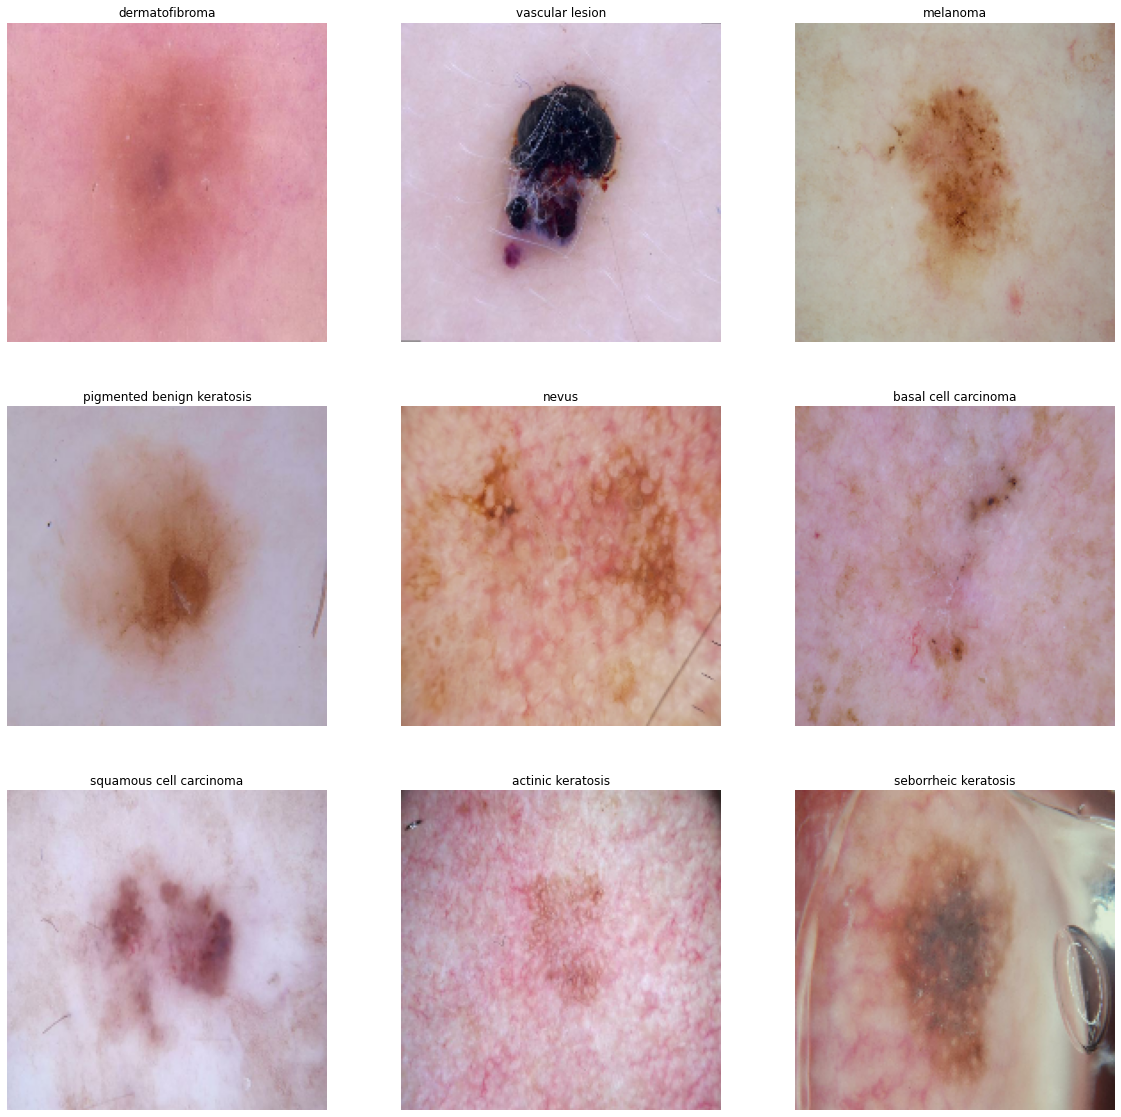

In [28]:
plt.figure(figsize=(20, 20))
count = 0
for key in image_dict :
    ax = plt.subplot(3,3, count + 1)
    plt.imshow(np.asarray(image_dict[key]).astype("uint8"))
    plt.title(names_dict[key])
    plt.axis("off")
    count += 1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
### Your code goes here
def make_model(input_shape, num_classes, dropout_prob, data_augment=False,layer_size=[128, 256, 512, 728]):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    if data_augment:
        x = data_augmentation(inputs)
    else:
        x = inputs
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #(180,180,3)
    x = layers.Conv2D(32, 3, strides=2, padding="valid")(x)
    #(178,178,3)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    #(176,176,3)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(128, 2, padding="valid")(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    activation = "softmax"
    units = num_classes
    x = layers.Dropout(dropout_prob)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [31]:
model = make_model(input_shape=(img_height,img_width) + (3,), num_classes=9,dropout_prob=0)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [32]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 89, 89, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 89, 89, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 88, 88, 128)       3289

### Train the model

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 41s 81ms/step - loss: 2.6874 - accuracy: 0.2533 - val_loss: 1.4185 - val_accuracy: 0.4870
Epoch 2/20
169/169 [==============================] - 7s 39ms/step - loss: 1.3795 - accuracy: 0.4914 - val_loss: 1.1911 - val_accuracy: 0.5635
Epoch 3/20
169/169 [==============================] - 7s 39ms/step - loss: 1.1733 - accuracy: 0.5771 - val_loss: 1.1623 - val_accuracy: 0.5672
Epoch 4/20
169/169 [==============================] - 7s 39ms/step - loss: 0.9780 - accuracy: 0.6427 - val_loss: 1.1221 - val_accuracy: 0.6073
Epoch 5/20
169/169 [==============================] - 7s 39ms/step - loss: 0.8487 - accuracy: 0.6968 - val_loss: 0.9569 - val_accuracy: 0.6667
Epoch 6/20
169/169 [==============================] - 7s 39ms/step - loss: 0.6789 - accuracy: 0.7712 - val_loss: 0.8696 - val_accuracy: 0.7194
Epoch 7/20
169/169 [==============================] - 7s 40ms/step - loss: 0.5533 - accuracy: 0.8279 - val_loss: 0.9923 - val_accuracy: 0.672

### Visualizing training results

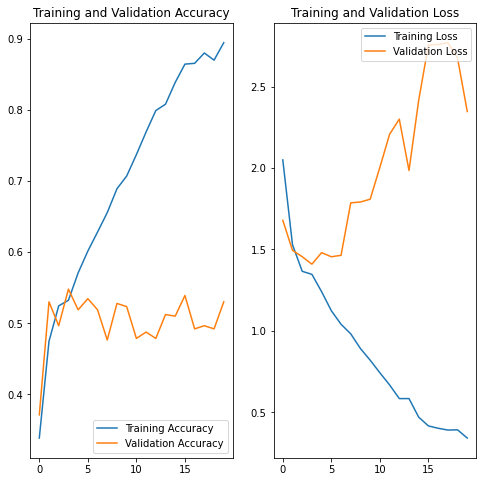

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

* As we can observe the model is overfitting. 
* The training accuracy hits 90 %  and loss decreases monotonically but the validation accuracy plateaus and loss increases.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.8),
        layers.experimental.preprocessing.RandomContrast(0.1)
    ]
)


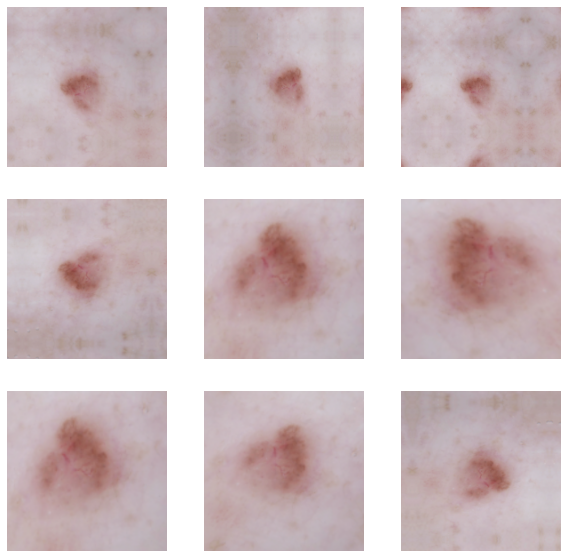

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = make_model(input_shape=(img_height,img_width) + (3,), num_classes=9,dropout_prob=0,data_augment=True)

### Compiling the model

In [ ]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.6960 - accuracy: 0.2289 - val_loss: 1.7559 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.7634 - accuracy: 0.3423 - val_loss: 1.6107 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5880 - accuracy: 0.4363 - val_loss: 1.6416 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.6545 - accuracy: 0.3860 - val_loss: 1.5404 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 2s 45ms/step - loss: 1.5644 - accuracy: 0.4127 - val_loss: 1.5005 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4569 - accuracy: 0.4899 - val_loss: 1.5123 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5430 - accuracy: 0.4575 - val_loss: 1.6376 - val_accuracy: 0.4541
Epoch 8/20
56

### Visualizing the results

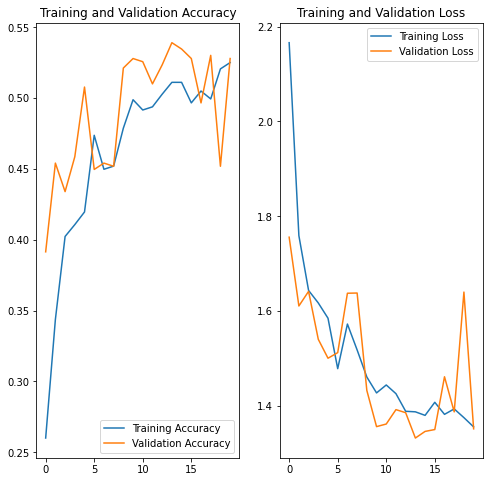

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We can now see that the model is underfitting as both the training and validation accuracy are fairly low.
* No evidence of overfitting is there as the validation accuracy is always very close to training.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
all_images = list(train_ds)

In [ ]:
count = np.array([0]*9)
for i in range(len(all_images)):
    count_i = np.sum(all_images[i][1],axis=0)
    count = count + count_i

In [ ]:
print(dict(zip(class_names,count)))

{'actinic keratosis': 92.0, 'basal cell carcinoma': 309.0, 'dermatofibroma': 77.0, 'melanoma': 352.0, 'nevus': 277.0, 'pigmented benign keratosis': 370.0, 'seborrheic keratosis': 58.0, 'squamous cell carcinoma': 142.0, 'vascular lesion': 115.0}


- seborrheic keratosis has the least number of sample 58
- pigmented benign keratosis has the highest number of samples 370


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
import os
print(os.getcwd())
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content
./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBEAA1ED828>: 100%|██████████| 500/500 [00:19<00:00, 25.33 Samples/s]


./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBF096CF048>: 100%|██████████| 500/500 [00:19<00:00, 25.66 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBEAA192BE0>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBF096ADF98>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBF096E6390>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBF096F0390>:   0%|          | 1/500 [00:00<01:01,  8.10 Samples/s]

Initialised with 462 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBEAA6092E8>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBF096E2E48>: 100%|██████████| 500/500 [00:42<00:00, 11.86 Samples/s]


./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBEAA1F56D8>: 100%|██████████| 500/500 [00:19<00:00, 26.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to ./drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBEAA1ED080>: 100%|██████████| 500/500 [00:19<00:00, 25.47 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
df2['Label'].value_counts()

seborrheic keratosis          500
melanoma                      500
basal cell carcinoma          500
squamous cell carcinoma       500
pigmented benign keratosis    500
vascular lesion               500
nevus                         500
actinic keratosis             500
dermatofibroma                500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [35]:
## your code goes
model = make_model(input_shape=(img_height,img_width) + (3,), num_classes=9,dropout_prob=0.12,data_augment=False)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
## your code goes here
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 7s 41ms/step - loss: 2.1421 - accuracy: 0.2867 - val_loss: 1.3541 - val_accuracy: 0.4952
Epoch 2/30
169/169 [==============================] - 7s 40ms/step - loss: 1.3027 - accuracy: 0.5184 - val_loss: 1.2371 - val_accuracy: 0.5679
Epoch 3/30
169/169 [==============================] - 7s 40ms/step - loss: 1.0914 - accuracy: 0.5992 - val_loss: 1.0791 - val_accuracy: 0.6132
Epoch 4/30
169/169 [==============================] - 7s 40ms/step - loss: 0.8613 - accuracy: 0.6991 - val_loss: 1.1139 - val_accuracy: 0.6281
Epoch 5/30
169/169 [==============================] - 7s 41ms/step - loss: 0.7376 - accuracy: 0.7514 - val_loss: 0.9227 - val_accuracy: 0.7275
Epoch 6/30
169/169 [==============================] - 7s 41ms/step - loss: 0.5915 - accuracy: 0.8064 - val_loss: 0.9321 - val_accuracy: 0.7394
Epoch 7/30
169/169 [==============================] - 7s 41ms/step - loss: 0.4515 - accuracy: 0.8674 - val_loss: 1.0105 - val_accuracy: 0.7120

#### **Todo:**  Visualize the model results

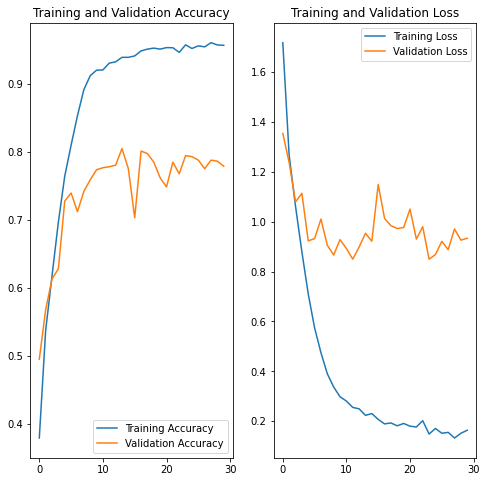

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We see that still some overfitting remains. But the class rebalancing has increased the validation accuracy by almost 30%.


